<a href="https://colab.research.google.com/github/phanee16/name1/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

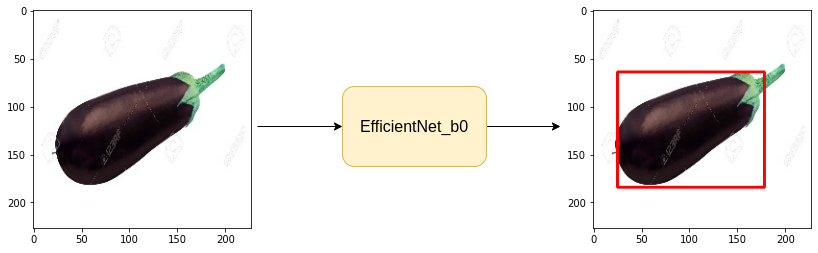

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-59sc_hhy
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-59sc_hhy
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:

csv_file = '/content/object-localization-dataset/train.csv'
data_dir = '/content/object-localization-dataset/'

# Device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Device = 'cuda'
Batch_size = 16
Image_size = 140
learning_rate = 0.001
epochs = 40
model_name = 'efficientnet_b0'
num_cor = 4

In [6]:
df = pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [7]:
df.describe()

,xmin,ymin,xmax,ymax,width,height
count,186.000000,186.000000,186.000000,186.000000,186.0,186.0
mean,36.150538,48.290323,193.252688,182.704301,227.0,227.0
std,25.524316,24.898749,23.673582,24.470030,0.0,0.0
min,1.000000,1.000000,88.000000,121.000000,227.0,227.0
25%,18.250000,29.000000,181.000000,165.000000,227.0,227.0
50%,29.000000,45.500000,197.500000,185.000000,227.0,227.0
75%,50.750000,67.000000,210.000000,201.000000,227.0,227.0
max,146.000000,136.000000,226.000000,227.000000,227.0,227.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  186 non-null    object
 1   xmin      186 non-null    int64 
 2   ymin      186 non-null    int64 
 3   xmax      186 non-null    int64 
 4   ymax      186 non-null    int64 
 5   width     186 non-null    int64 
 6   height    186 non-null    int64 
 7   label     186 non-null    object
dtypes: int64(6), object(2)
memory usage: 11.8+ KB


# Understand the dataset

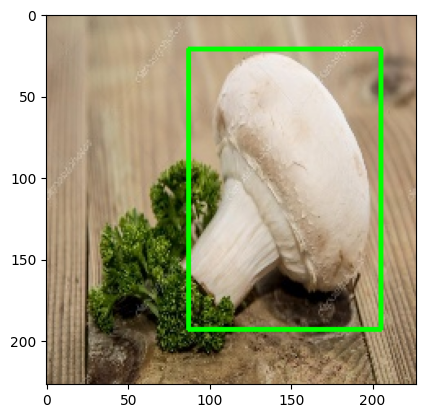

In [9]:
row = df.iloc[5]
img = cv2.imread(data_dir+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Draw rectangle
color = (0, 255, 0)
thickness = 2
cv2.rectangle(img, (row.xmin, row.ymin), (row.xmax, row.ymax), color, thickness)
plt.imshow(img)





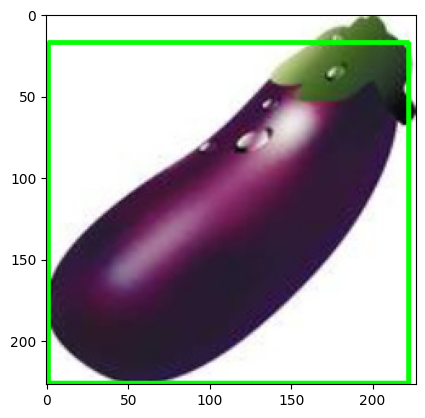

In [10]:
row = df.iloc[40]
img = cv2.imread(data_dir+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Draw rectangle
color = (0, 255, 0)
thickness = 2
cv2.rectangle(img, (row.xmin, row.ymin), (row.xmax, row.ymax), color, thickness)
plt.imshow(img)

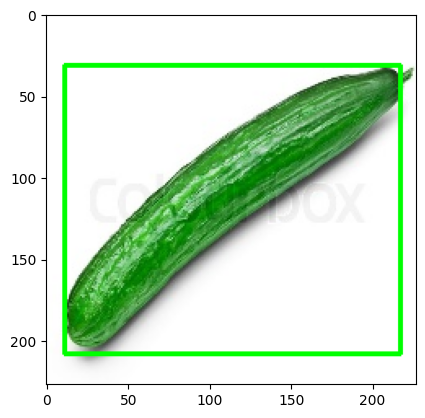

In [11]:
row = df.iloc[182]
img = cv2.imread(data_dir+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Draw rectangle
color = (0, 255, 0)
thickness = 2
cv2.rectangle(img, (row.xmin, row.ymin), (row.xmax, row.ymax), color, thickness)
plt.imshow(img)

In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
len(train_df)

148

# Augmentations

In [14]:
import albumentations as A

In [15]:
train_augs = A.Compose([
    A.Resize(Image_size,Image_size),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
],bbox_params = A.BboxParams(format='pascal_voc',label_fields=['class_labels'] ))


valid_augs = A.Compose([
    A.Resize(Image_size,Image_size),
],bbox_params = A.BboxParams(format='pascal_voc',label_fields=['class_labels'] ))

# Create Custom Dataset

In [16]:
# from pandas.io.pytables import DataCol
# import torch
# import cv2
# import pandas as pd

class ObjectDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        # self.data_dir = data_dir
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.xmax

        bbox = [[xmin,ymin,xmax,ymax]]
        img_path= data_dir + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1)/255.0
        bbox = torch.Tensor(bbox)
        return img,bbox



In [17]:
train_set = ObjectDetectionDataset(train_df,train_augs)
valid_set = ObjectDetectionDataset(val_df,valid_augs)

In [18]:
print("The total examples in the train set: ",len(train_set))
print("The total examples in the train set: ",len(valid_set))

The total examples in the train set:  148
The total examples in the train set:  38


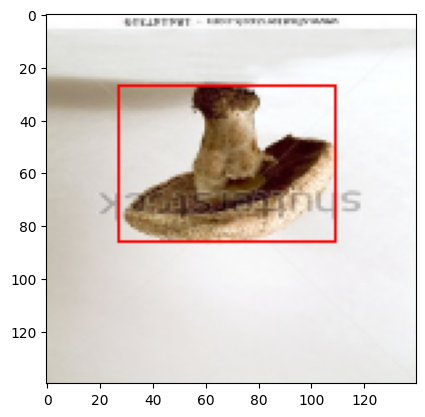

In [19]:
img,bbox = train_set[16]
xmin,ymin,xmax,ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

# Draw bounding box on the image
bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255, 0, 0), 1)
plt.imshow(bnd_img)


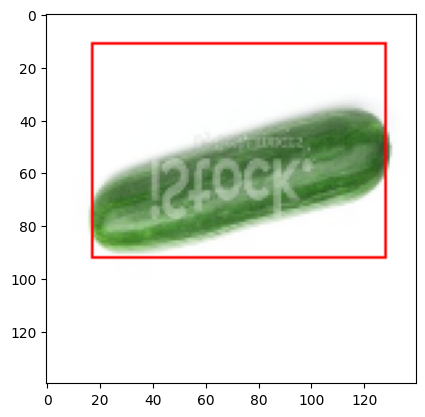

In [20]:
img,bbox = train_set[116]
xmin,ymin,xmax,ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

# Draw bounding box on the image
bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255, 0, 0), 1)
plt.imshow(bnd_img)

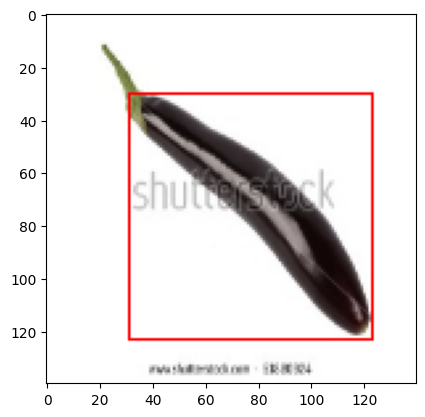

In [21]:
img,bbox = train_set[54]
xmin,ymin,xmax,ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

# Draw bounding box on the image
bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255, 0, 0), 1)
plt.imshow(bnd_img)

# Load dataset into batches

In [22]:
trainloader = torch.utils.data.DataLoader(train_set,batch_size= Batch_size, shuffle= True)
validloader = torch.utils.data.DataLoader(valid_set,batch_size= Batch_size, shuffle= False)

In [23]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [24]:
for images,bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [25]:
from torch import nn
import timm

In [26]:

class ObjectDetectionModel(nn.Module):
    def __init__(self):
      super(ObjectDetectionModel,self).__init__()

      self.backbone = timm.create_model(model_name,pretrained = True, num_classes = 4)

    def forward(self,images, gt_bboxes = None):
      bboxes = self.backbone(images)

      if gt_bboxes!= None:
          loss= nn.MSELoss()(bboxes,gt_bboxes)
          return bboxes,loss

      return bboxes


In [27]:
model = ObjectDetectionModel()
model.to(Device)

ObjectDetectionModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kern

In [28]:
random_img =  torch.rand(1, 3, 140, 140).to(Device)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [29]:
def train_fn(model,DataLoader,optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(DataLoader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(Device), gt_bboxes.to(Device)

    bboxes, loss = model(images,gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(DataLoader)

In [30]:
def eval_fn(model,DataLoader,optimizer):
  total_loss = 0.0
  model.eval()


  with torch.no_grad():

    for data in tqdm(DataLoader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(Device), gt_bboxes.to(Device)

      bboxes, loss = model(images,gt_bboxes)

      # optimizer.zero_grad()
      # loss.backward()
      # optimizer.step()

      total_loss += loss.item()

    return total_loss/len(DataLoader)

#Training Loop

In [31]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [32]:

best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model, validloader,optimizer)

  if valid_loss< best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1} train loss : {train_loss} , valid loss : {valid_loss}')




  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 1 train loss : 5359.048291015625 , valid loss : 1385.0039876302083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 train loss : 2066.0910522460936 , valid loss : 2153.941121419271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 3 train loss : 1136.0382568359375 , valid loss : 337.5088195800781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 train loss : 733.57333984375 , valid loss : 373.74009195963544


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 5 train loss : 611.5062133789063 , valid loss : 217.6077880859375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss : 456.9671264648438 , valid loss : 234.83265686035156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 7 train loss : 328.8599060058594 , valid loss : 147.98644002278647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss : 284.71814422607423 , valid loss : 356.12950642903644


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 train loss : 218.37543029785155 , valid loss : 215.49641927083334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss : 185.83875427246093 , valid loss : 204.97968546549478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss : 170.03004608154296 , valid loss : 252.70879109700522


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss : 156.25140075683595 , valid loss : 159.0516103108724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 13 train loss : 124.94039001464844 , valid loss : 115.3137715657552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss : 174.4605842590332 , valid loss : 119.73474629720052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss : 151.76478958129883 , valid loss : 155.82950846354166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 122.2493682861328 , valid loss : 237.53744506835938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 99.7122615814209 , valid loss : 168.9296671549479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss : 118.91949615478515 , valid loss : 137.06619517008463


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 19 train loss : 89.23775100708008 , valid loss : 93.81612904866536


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss : 66.46282272338867 , valid loss : 117.77851104736328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 21 train loss : 88.79494152069091 , valid loss : 93.49035135904948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss : 83.23270111083984 , valid loss : 116.53284708658855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 80.813916015625 , valid loss : 119.05610656738281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 24 train loss : 80.67487106323242 , valid loss : 89.68817647298177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 67.27846298217773 , valid loss : 115.81482696533203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss : 74.4328109741211 , valid loss : 116.8206303914388


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 27 train loss : 70.66394271850587 , valid loss : 85.71683883666992


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss : 70.99178733825684 , valid loss : 111.71665954589844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss : 65.00331916809083 , valid loss : 90.71335856119792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 63.25513744354248 , valid loss : 95.20207214355469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 68.9057830810547 , valid loss : 94.28174845377605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 32 train loss : 61.63403968811035 , valid loss : 79.26478703816731


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss : 66.01847038269042 , valid loss : 102.21897888183594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 55.67130584716797 , valid loss : 129.26878102620444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 61.08401527404785 , valid loss : 95.38492329915364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 67.64524116516114 , valid loss : 85.04825337727864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 56.573556900024414 , valid loss : 85.36380767822266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 48.66095962524414 , valid loss : 104.97019704182942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 39 train loss : 49.147304916381835 , valid loss : 76.57742309570312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 40 train loss : 53.98733768463135 , valid loss : 63.99126434326172


#Inference

In [33]:
import utils

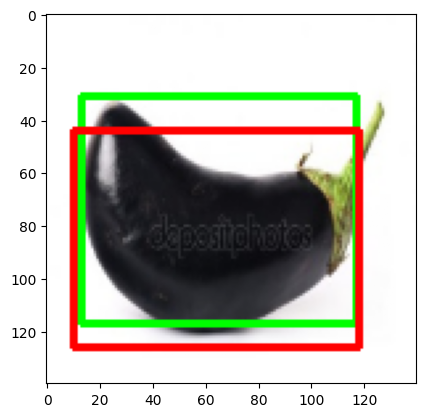

In [34]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image,gt_bbox = valid_set[6]
  image = image.unsqueeze(0).to(Device)
  out_bbox = model(image)

  utils.compare_plots(image,gt_bbox, out_bbox)